# Introduction: Book Recommendation System

In this notebook, we will build a book recommendation system based on a simple principle: books with Wikipedia pages that link to similar Wikipedia pages are similar to each other. In order to create this representation of similar books, we'll use the concept of neural network entity embeddings, mapping each book and each Wikipedia link (Wikilink) to a 50-number vector. 

The idea of entity embeddings is to map high-dimensional categorical variables to a low-dimensional _learned_ representation that _places similar entities closer together in the embedding space_. If we were to one-hot-encode the books (another representation of categorical data) we would have a 37,000 dimension vector for each book, with a single 1 indicating the book. In a one-hot encoding, similar books would not be "closer" to one another. By  training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the books, we also get a representation that _keeps similar books closer to each other_. Therefore, the basic approach for a recommendation system is to create entity embeddings of all the books, and then for any book, find the closest other books in the embedding space. [Fortunately, thanks to a previous notebook](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb), we have access to every single book article on Wikipedia, which will let us create an effective recommendation system.

## Approach

To create entity embeddings, we need to build an embedding neural network and train it on a supervised machine learning task that will result in similar books (and similar links) having closer representations in embedding space. The parameters of the neural network - the weights - are the embeddings, and so during training, these numbers are adjusted to minimize the loss on the prediction problem. In other words, the network tries to accurately complete the task by changing the representations of the books and the links. 

Once we have the embeddings for the books and the links, we can find the most similar book to a given book by computing the distance between the embedded vector for that book and all the other book embeddings. We'll use the cosine distance which measures the angle between two vectors as a measure of similarity (another valid option is the Euclidean distance). We can also do the same with the links, finding the most similar page to a given page. (I use links and wikilinks interchangeably in this notebook). The steps we will follow are:

1. Load in data and clean
2. Prepare data for supervised machine learning task
3. Build the entity embedding neural network
4. Train the neural network on prediction task
5. Extract embeddings and find most similar books and wikilinks
6. Visualize the embeddings using dimension reduction techniques 

### Supervised Machine Learning Task: Map Books to Links

For our machine learning task, we'll set up the problem as identifying whether or not a particular link was present in a book article. The training examples will consist of (book, link) pairs, with some pairs true examples - actually  in the data - and others negative examples - do not occur in the data. It will be the network's job to adjust the entity embeddings of the books and the links in order to accurately make this classification. Although we are training for a supervised machine learning task, our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings, so we do not use a validation or testing set. We use the prediction problem as a means to an end rather than the final outcome. 

## Neural Network Embeddings

Neural Network embeddings have proven to be very powerful concepts both for modeling language and for representing categorical variables. For example, the [Word2Vec word embeddings](https://www.tensorflow.org/tutorials/representation/word2vec) map a word to a vector based on training a neural network on millions of words. These embeddings can be used in any supervised model because they are just numerical representations of categorical variables. Much as we one-hot-encode categorical variables to use them in a random forest for a supervised task, we can also use entity embeddings to include categorical variables in a model. The embeddings are also useful because we can find entities that are close to one another in embedding space which might - as in a book recommendation system - allow us to find the most similar categories among tens of thousands of choices. 

We can also use the Entity Embeddings to visualize words or categorical variables, such as creating a map of all books on Wikipedia. The entity embeddings typically are still high-dimensional - we'll use 50 numbers for each entity - so we need to use a dimension reduction technique such as TSNE or UMAP to visualize the embeddings in lower dimensions. (These are both manifold embedding methods so in effect we will embed the embeddings for visualization!) We'll take a look at doing this at the end of the notebook and later will upload the embeddings into a application custom-built for this purpose ([projector.tensorflow.org](https://projector.tensorflow.org)). Entity embeddings are becoming more widespread thanks to the ease of development of neural networks in Keras and are a useful approach when we want to represent categorical variables with vectors that place similar categories close to one another. Other approaches for encoding categorical variables do not represent similar entities as being closer to one another, and entity embedding is a _learning-based method_ for this important task.

Overall, this project is a great look at the potential for neural networks to create meaningful embeddings of high dimensional data and a practical application of deep learning. The code itself is relatively simple, and the Keras library makes developing deep learning models enjoyable!

The code here is adapted from the excellent [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do), the [notebooks for which can be found on GitHub](https://github.com/DOsinga/deep_learning_cookbook). Check out this book for practical applications of deep learning and great projects! 

__Note to Kaggle users__: Make sure GPU is enabled and Internet is connected on the Settings pane.

## Read in Data

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the [Downloading and Parsing Wikipedia Data Notebook](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb).

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from keras.utils import get_file

x = get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Found 37020 books.


In [4]:
#books_with_wikipedia[:1]
len(books_with_wikipedia)

20

In [5]:
#books[:1]
len(books)

37020

## Data Cleaning

There are a few articles that were caught which are clearly not books (feel free to check out these articles yourself).

In [6]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

Each legitimate book contains the __title, the information from the `Infobox book` template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article__ (a rough estimate of the length of the article).

In [7]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'name': 'Limonov',
  'author': 'Emmanuel Carrère',
  'translator': 'John Lambert',
  'country': 'France',
  'language': 'French',
  'publisher': 'P.O.L.',
  'pub_date': '2011',
  'english_pub_date': '2014',
  'pages': '488',
  'isbn': '978-2-8180-1405-9'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

We will only use the wikilinks, which are saved as the third element (index 2) for each book.

## Map Books to Integers

First we want to create a mapping of book titles to integers. When we feed books into the embedding neural network, we will have to represent them as numbers, and this mapping will let us keep track of the books. We'll also create the reverse mapping, from integers back to the title.

In [8]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

### Exploring Wikilinks

Although it's not our main focus, we can do a little exploration. Let's find the number of unique Wikilinks  and the most common ones. To create a single list from a list of lists, we can use the `itertools` chain method.

In [9]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


How many of these are links to other books?

In [10]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

There are 17032 unique wikilinks to other books.


### Most Linked-to Articles

Let's take a look at which pages are most linked to by books on Wikipedia. 

We'll make a utility function that takes in a list and returns a sorted ordered dictionary of the counts of the items in the list. The `collections` module has a number of useful functions for dealing with groups of objects.

In [11]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in 'l'"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by higest count first and place in oredered dictionary
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    counts = OrderedDict(counts)
    
    return counts

We only want to count wikilinks from each book once, so we first find the set of links for each book, then we flatten the list of lists to a single list, and finally pass it to the `count_items` function.

In [12]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

The most linked to pages are in fact not that surprising! One thing we should notice is that there are discrepancies in capitalization. We want to normalize across capitalization, so we'll lowercase all of the links and redo the counts.

In [13]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

That actually changes the rankings! This illustrates an important point: __make sure to take a look at your data before modeling!__ 

#### Remove Most Popular Wikilinks

I'm going to remove the __most popular__ wikilinks because these are not very informative. Knowing whether a book is hardcover or paperback is not that important to the content. We also don't need the two `Wikipedia:` links since these do not distinguish the books based on content. __I'd recommend playing around with the wikilinks that are removed because it might have a large effect on the recommendations.__

(This step is similar to the idea of [TF-IDF (Term Frequency Inverse Document Frequency](http://www.tfidf.com/). When dealing with words in documents, the words that appear most often across documents are usually not that helpful because they don't distinguish documents. TF-IDF is a way to weight a word higher for appearing more often within an article but decrease the weighting for a word appearing more often between articles.)

In [14]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

Since there are so many unique wikilinks, I'm going to limit the list to wikilinks mentioned 4 or more times. Hopefully this reduces the noise that might come from wikilinks that only appear a few times. Keeping every single link will increas the training time significantly, but experiment with this parameter if you are interested.

In [15]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


#### Most Linked-to Books

As a final bit of exploration, let's look at the books that are mentioned the most by other books on Wikipedia. We'll take the set of links for each book so that we don't have multiple counts for books that are linked to by another book more than once. 

In [17]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

It's not surprising that several of these are references. We also see that a few classics make it into the list! 

### Potential Additional Cleaning Step

If you want to try more data cleaning, one option would be to clean the link entities. For example, both `the new york times` and `new york times` are in the links. These could clearly be combined into a single entry because they link to the same exact page. This might require manual inspection of the links, and I decided not to do this because of the time involved! The final embeddings turned out well even without this step, but it might make sense to do in the future. 

I'm not sure why the same link is represented as two different names (I extracted the title of the link to try and alleviate this issue), but it occurs many times, even for the same book! 

In [21]:
for book in books:
    if "The New York Times" in book[2] and "New York Times" in book[2]:
        print(book[0], "\n" ,book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays 
 ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [24]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

2742

996

## Wikilinks to Index

As with the books, we need to map the Wikilinks to integers. We'll also create the reverse mapping.

In [25]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


# Supervised Machine Learning Task

Now that we have clean data, we'll move on to the second step: developing a supervised machine learning task to train an embedding neural network. As a reminder, we'll state the problem as: given a book title and a link, identify if the link is in the book's article.

## Build a Training Set

In order for any machine learning model to learn, it needs a training set. We are going to treat this as a supervised learning problem: given a pair (book, link), we want the neural network to learn to predict whether this is a legitimate pair - present in the data - or not.

To create a training set, for each book, we'll iterate through the wikilinks on the book page and record the book title and each link as a tuple. The final `pairs` list will consist of tuples of every (book, link) pairing on all of Wikipedia.

In [31]:
books[0][2]

['Sigmund Freud',
 'Dell Publishing',
 'Hardcover',
 'Paperback',
 'Sigmund Freud',
 'Erich Fromm',
 'Dell Publishing',
 'Anna Freud',
 'Ernest Jones',
 'Carl Jung',
 'Wilhelm Stekel',
 'Fritz Wittels',
 'Maurice English',
 'The Nation',
 'Frederick Crews',
 'The New York Review of Books',
 'Peter Gay',
 'Freud: A Life for Our Time',
 'The Life and Work of Sigmund Freud',
 'Louis Breger',
 'Wilhelm Fliess',
 'Freud family',
 'Cambridge University Press',
 'John Wiley  &  Sons',
 'Dell Publishing',
 'Papermac',
 'The Nation',
 'The New York Review of Books',
 'Category:1947 books',
 'Category:Books about Sigmund Freud',
 'Category:English-language books']

In [35]:
from tqdm import tqdm

pairs = []

# Iterate through each ook
for book in tqdm(books):
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)
pairs[5000]

100%|██████████| 37020/37020 [15:13<00:00, 40.55it/s] 


(772798, 41758, 37020)

(321, 232)

We now have over 770,000 positive examples on which to train! Each pair represents one Wikilink for one book. Let's look at a few examples.

In [50]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

('Slaves in the Family', 'category:american biographies')

In [53]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

Later on we'll create the negative examples by randomly sampling from the links and the books and making sure the resulting pair is not in `pairs`. 

In [54]:
pairs_set = set(pairs)

Just for fun, let's look at the (book, link) pairs that are represented most often in the data. 

In [55]:
x = Counter(pairs)
sorted(x.items(), key=lambda x: x[1], reverse=True)[:5]

[((13337, 31112), 85),
 ((31899, 65), 77),
 ((25899, 8850), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [56]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'hydrophobie (song)')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

There's nothing wrong with books that link to the same page many times. They are just more likely to be trained on since there are more of them.

## Note about Training / Testing Set

To compute the embeddings, we are not going to create a separate validation or testing set. While this is a __must__ for a normal supervised machine learning task, in this case, our primary objective is not to make the most accurate model, but to generate the best embeddings. The prediction task is just the method through which we train our network to make the embeddings. At the end of training, we are not going to be testing our model on new data, so we don't need to evaluate the performance. Instead of testing on new data, we'll look at the embeddings themselves to see if books that we think are similar have embeddings that are close to each other. 

If we kept a separate validation / testing set, then we would be limiting the amount of data that our network can use to train. This would result in less accurate embeddings. Normally with any supervised model, we need to be concerned about overfitting, but again, because we do not need our model to generalize to new data and our goal is the embeddings, we will make our model as effective as possible by using all the data for training. In general, always have a separate validation and testing set (or use cross validation) and make sure to regularize your model to prevent overfitting. 

## Generator For Training Samples

We need to generate positive samples and negative samples to train the neural network. The positive samples are simple: pick a pair from `pairs` and assign it a 1. The negative samples are also fairly easy: pick one random link and one random book, make sure they are not in `pairs`, and assign them a -1 or a 0. (We'll use either a -1 or 0 for the negative labels depending on whether we want to make this a regression or a classification problem. Either approach is valid, and we'll try out both methods.)

The code below creates a generator that yields batches of samples each time it is called. Neural networks are trained incrementally - a batch at a time - which means that a generator is a useful function for returning examples on which to train. Using a generator alleviates the need to store all of the training data in memory which might be an issue if we were working with a larger dataset such as images. 

In [57]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive=50, negative_ratio=1.0, classification=False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
        
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)
        
        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

To get a new batch, call `next` on the generator.

In [58]:
next(generate_batch(pairs, n_positive=2, negative_ratio=2))

({'book': array([22162., 25757.,  6895.,  7206., 28410., 29814.]),
  'link': array([ 5588., 22920.,   260., 34924., 33217., 11452.])},
 array([ 1., -1.,  1., -1., -1., -1.]))

In [63]:
x, y = next(generate_batch(pairs, n_positive=2, negative_ratio=2))

# Show a few sample training paris
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}')

Book: The Secrets of Midwives        Link: introducing... (book series)             Label: -1.0
Book: The Castle (novel)             Link: kurt wolff (publisher)                   Label: 1.0
Book: Road to Nandikadal             Link: luck                                     Label: -1.0
Book: Miracles Ain't What They Used To Be Link: technocracy                              Label: -1.0
Book: Kangaroo Notebook              Link: japanese language                        Label: 1.0
Book: Work Like Any Other            Link: subspecies                               Label: -1.0


The neural network will take in the book index and the link index and try to embed them in such a way that it can predict the label from the embeddings.

# Neural Network Embedding Model

With our dataset and a supervised machine learning task, we're almost there. The next step is the most technically complicated but thankfully fairly simple with Keras. We are going to construct the neural network that learns the entity embeddings. The input to this network is the (book, link) (either positive or negative) as integers, and the output will be a prediction of whether or not the link was present in the book article. However, we're not actually interested in the prediction except as the device used to train the network by comparison to the label. What we are after is at the heart of the network: the embedding layers, one for the book and one for the link each of which maps the input entity to a 50 dimensional vector. The layers of our network are as follows:

1. Input: parallel inputs for the book and link
2. Embedding: parallel embeddings for the book and link
3. Dot: computes the dot product between the embeddings to merge them together
4. Reshape: utility layer needed to correct the shape of the dot product
5. [Optional] Dense: fully connected layer with sigmoid activation to generate output for classification

After converting the inputs to an embedding, we need a way to combine the embeddings into a single number. For this we can use the dot product which does element-wise multiplication of numbers in the vectors and then sums the result to a single number. This raw number (after reshaping) is then the ouput of the model for the case of regression. In regression, our labels are either -1 or 1, and so the model loss function will be mean squared error in order to minimize the distance between the prediction and the output. Using the dot product with normalization means that the `Dot` layer is finding the cosine similarity between the embedding for the book and the link. Using this method for combining the embeddings means we are trying to make the network learn similar embeddings for books that link to similar pages. 

### Classification vs Regression

For classification, we add an extra fully connected `Dense` layer with a `sigmoid` activation to squash the outputs between 0 and 1 because the labels are either 0 or 1. The loss function for classification is `binary_crossentropy` which measures the [error of the neural network predictions in a binary classification problem](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), and is a measure of the similarity between two distributions. We can train with either classification or regression, and in practice, I found that both approaches produced similar embeddings. I'm not sure about the technical merits of these methods, and I'd be interested to hear if one is better than the other. 

The optimizer - the algorithm used to update the parameters (also called weights) of the neural network after calculating the gradients through backpropagation - is Adam in both cases ([Adam is a modification to Stochastic Gradient Descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). We use the default parameters for this optimizer. The nice thing about modern neural network frameworks is we don't have to worry about backpropagation or updating the model parameters because that is done for us. It's nice to have an idea of what is occuring behind the scenes, but it's not entirely necessary to use a neural network effectively. 

In [65]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [111]:
def book_embedding_model(embedding_size=50, classification=False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name='book', shape=[1])
    link = Input(name='link', shape=[1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name='book_embedding',
                               input_dim=len(book_index),
                               output_dim=embedding_size)(book)
                            
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name='link_embedding',
                               input_dim=len(link_index),
                               output_dim=embedding_size)(link)

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name='dot_product', normalize=True, axes=2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape=[1])(merged)
    
    # If classification, add extra layer and loss function is ninary cross entropy
    if classification:
        merged = Dense(1, activation='sigmoid')(merged)
        model = Model(inputs=[book, link], outputs=merged)
        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Otherwise loss function is mearn squared error
    else:
        model = Model(inputs=[book, link], outputs=merged)
        model.compile(optimizer='Adam', loss='mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        2087900     link[0][0]                       
____________________________________________________________________________________________

There are nearly 4.0 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data. 

# Train Model

We have the training data - in a generator - and a model. The next step is to train the model to learn the entity embeddings. During this process, the model will update the embeddings (change the model parameters) to accomplish the task of predicting whether a certain link is on a book page or not. The resulting embeddings can then be used as a representation of books and links. 

There are a few parameters to adjust for training. The batch size should generally be as large as possible given the memory constraints of your machine. The negative ratio can be adjusted based on results. I tried 2 and it seemed to work well. The number of steps per epoch is chosen such that the model sees a number of examples equal to the number of pairs on each epoch. This is repeated for 15 epochs (which might be more than necessary).

In [69]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio=2)

# Train
h = model.fit_generator(gen, epochs=15,
                        steps_per_epoch=len(pairs) // n_positive,
                        verbose=2)

/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1879: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
754/754 - 20s - loss: 0.9574
Epoch 2/15
754/754 - 22s - loss: 0.7283
Epoch 3/15
754/754 - 22s - loss: 0.5042
Epoch 4/15
754/754 - 17s - loss: 0.4616
Epoch 5/15
754/754 - 21s - loss: 0.4442
Epoch 6/15
754/754 - 20s - loss: 0.4349
Epoch 7/15
754/754 - 19s - loss: 0.4288
Epoch 8/15
754/754 - 22s - loss: 0.4248
Epoch 9/15
754/754 - 21s - loss: 0.4214
Epoch 10/15
754/754 - 18s - loss: 0.4190
Epoch 11/15
754/754 - 22s - loss: 0.4166
Epoch 12/15
754/754 - 24s - loss: 0.4151
Epoch 13/15
754/754 - 22s - loss: 0.4134
Epoch 14/15
754/754 - 22s - loss: 0.4124
Epoch 15/15
754/754 - 21s - loss: 0.4108


The loss decreases as training progresses which should give us confidence the model is learning something! 


The entire trained model can be saved and later loaded in so you don't have to repeat the training. It's also possible to save certain layers.

In [70]:
model.save('first_attempt.h5')

# Extract Embeddings and Analyze

The trained model has learned - hopefully - representations of books and wikilinks that place similar entities next to one another in the embedding space. To find out if this is the case, we extract the embeddings and use them to find similar books and links.

In [71]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

Each book is now represented as a 50-dimensional vector. 

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [73]:
book_weights = book_weights / np.linalg.norm(book_weights, axis=1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.04932573,  0.24271233,  0.0184103 ,  0.02342185, -0.03911161,
       -0.0759265 ,  0.17986672, -0.10726482, -0.22205798,  0.06928367],
      dtype=float32)

1.0

Normalize just means divide each vector by the square root of the sum of squared components.

# Finding Similar Books

We've trained the model and extracted the embeddings - great - but where is the book recommendation system? Now that we have the embeddings, we can use them to recommend books that our model has learned are most similar to a given book.


### Function to Find Most Similar Entities

The function below takes in either a book or a link, a set of embeddings, and returns the `n` most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the [cosine similarity](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/) between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name='book', n=10, least=False, return_dist=False, plot=False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and revers index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
        
    # Check to make sure `name` is in index
    try:
        # Calculate dot product betwwen book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) -1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n // 2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index=items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color=colors, figsize=(10, 8), 
                                   edgecolor='k', linewidth=2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x=0, color='k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x=0.2, size=28, y=1.05)
        
        return None

    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
        
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closes
        

        print(f'{index_name.capitalize()}s closest to {name}.\n')
    
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

(We know that this function works if the most similar book is the book itself. Because we multiply the item vector times all the other embeddings, the most similar should be the item itself with a similarity of 1.0.)

In [93]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: Anna Karenina               Similarity: 0.93
Book: The Master and Margarita    Similarity: 0.93
Book: Demons (Dostoevsky novel)   Similarity: 0.9
Book: Candide                     Similarity: 0.9
Book: Buddenbrooks                Similarity: 0.89
Book: Crime and Punishment        Similarity: 0.89
Book: Don Quixote                 Similarity: 0.88
Book: The Idiot                   Similarity: 0.87
Book: La Peau de chagrin          Similarity: 0.87


It works! The most similar books make sense at least for _War and Peace._

In [94]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Siege of Darkness               Similarity: -0.58
Book: Forgotten Realms Adventures     Similarity: -0.59
Book: Condemnation (novel)            Similarity: -0.59
Book: Preludes (Dragonlance series)   Similarity: -0.6
Book: Lords of Darkness               Similarity: -0.62


The least similar books are quite a grab bag!

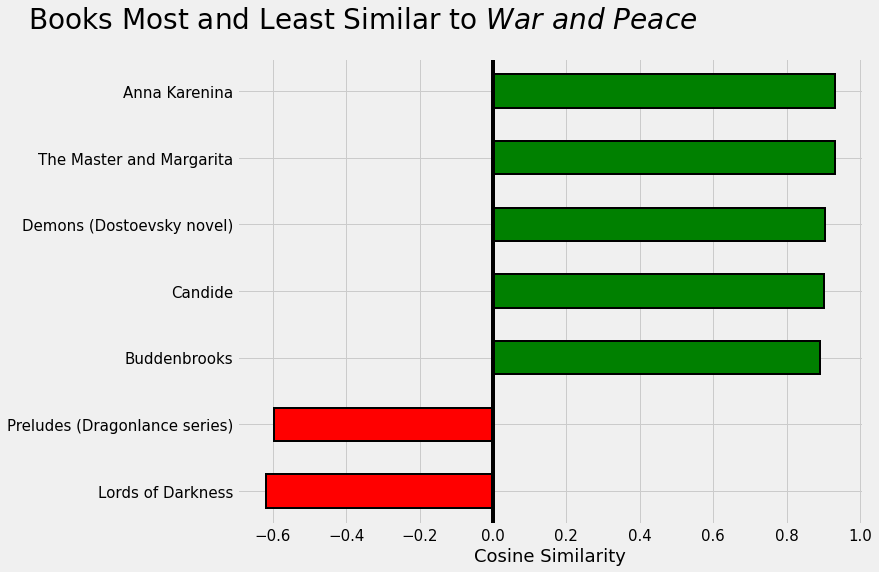

In [95]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [96]:
find_similar('The Fellowship of the Ring', book_weights, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Return of the King       Similarity: 0.96
Book: The Silmarillion             Similarity: 0.95
Book: The Two Towers               Similarity: 0.91
Book: Beren and Lúthien            Similarity: 0.9


It doesn't work perfectly for every book as we can see.

In [97]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach            Similarity: 1.0
Book: Computer Graphics: Principles and Practice            Similarity: 0.96
Book: Algorithms + Data Structures = Programs               Similarity: 0.95
Book: TCP/IP Illustrated                                    Similarity: 0.95
Book: Structure and Interpretation of Classical Mechanics   Similarity: 0.95


In [98]:
find_similar('Weapons of Math Destruction', book_weights, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction      Similarity: 1.0
Book: The Alchemy of Race and Rights   Similarity: 0.95
Book: Chief Culture Officer            Similarity: 0.93
Book: Huck's Raft                      Similarity: 0.92
Book: Hmong: History of a People       Similarity: 0.92


Not bad by the looks of the results! I encourage you to play around with the model and explore the resulting embeddings. __We have successfully built a book recommendation system using neural network embeddings.__

What should I read next? Currently I'm working through a fantastic collection of essays by Stephen Jay Gould.

In [99]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus     Similarity: 1.0
Book: Eight Little Piggies       Similarity: 0.97
Book: The Meme Machine           Similarity: 0.97
Book: Darwin on Trial            Similarity: 0.96
Book: The Panda's Thumb (book)   Similarity: 0.96


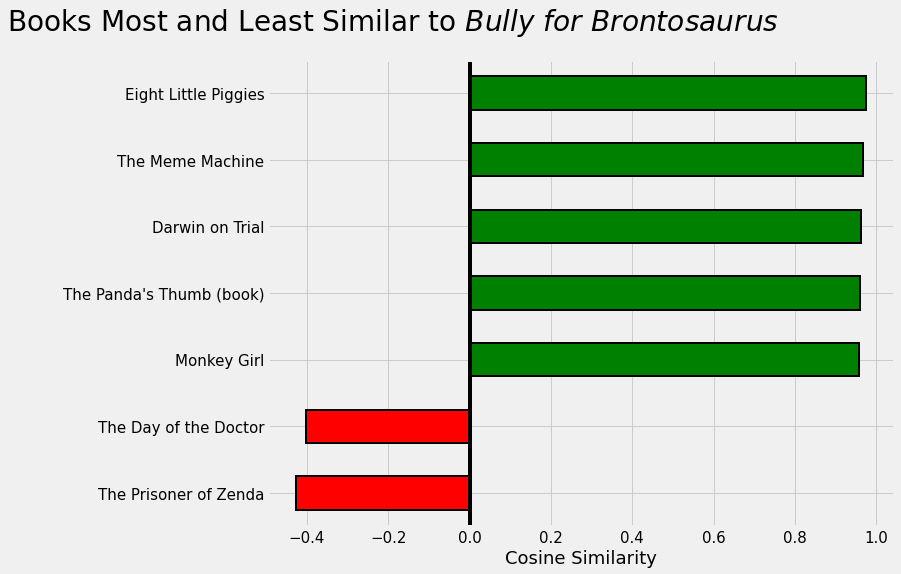

In [100]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

## Wikilink Embeddings

We also have the embeddings of wikipedia links (which are themselves Wikipedia pages). We can take a similar approach to extract these and find the most similar to a query page. 

Let's write a quick function to extract weights from a model given the name of the layer.

In [103]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [104]:
link_weights = extract_weights('link_embedding', model)

We can use the same `find_similar` function to find the most similar links to a given link.

In [106]:
find_similar('science fiction', link_weights, index_name='page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.98
Page: tor books                                  Similarity: 0.93
Page: ballantine books                           Similarity: 0.92
Page: bantam books                               Similarity: 0.9
Page: category:doubleday (publisher) books       Similarity: 0.9
Page: category:ballantine books books            Similarity: 0.89
Page: victor gollancz ltd                        Similarity: 0.89
Page: berkley books                              Similarity: 0.89
Page: category:tor books books                   Similarity: 0.88


Based on my knowledge, it appears the neural network embeddings are also a good representation of the pages! Not only can we find the most similar books to a given book, but if we have a category of books that we enjoy, we can find another category that is similar.

In [107]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: autobiography                         Similarity: 0.94
Page: non-fiction                           Similarity: 0.93
Page: category:american non-fiction books   Similarity: 0.93
Page: category:english-language books       Similarity: 0.93
Page: category:2003 books                   Similarity: 0.91
Page: category:2005 books                   Similarity: 0.91
Page: category:2007 books                   Similarity: 0.89
Page: oxford university press               Similarity: 0.89
Page: category:2009 books                   Similarity: 0.89


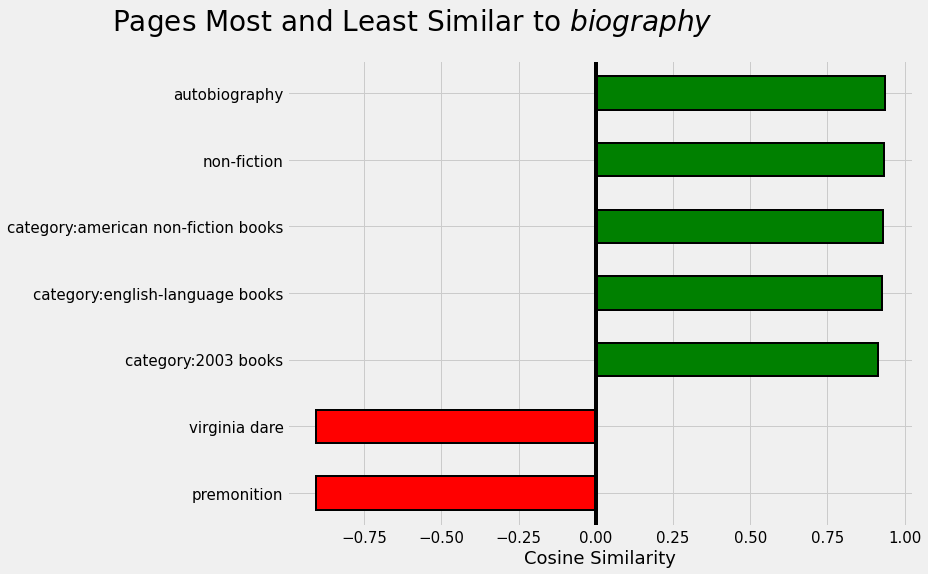

In [108]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

Now you not only know what books to look for, you know the books to avoid for a given category! 

In [109]:
find_similar('new york city', link_weights, index_name = 'page', n = 5)

Pages closest to new york city.

Page: new york city                    Similarity: 1.0
Page: the new york times               Similarity: 0.97
Page: alfred a. knopf                  Similarity: 0.96
Page: category:random house books      Similarity: 0.95
Page: category:alfred a. knopf books   Similarity: 0.95


## Classification Model

I was curious if training for the mean squared error as a regression problem was the ideal approach, so I also decided to experiment with a classification model. For this model, the negative examples receive a label of 0 and the loss function is binary cross entropy. The procedure for the neural network to learn the embeddings is exactly the same, only it will be optimizing for a slightly different measure.

In [112]:
model_class = book_embedding_model(50, classification=True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification=True)

In [ ]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs=15, steps_per_epoch=len(pairs) // n_positive, verbose=0)

/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1879: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


We'll go through the same process, extracting the weights and finding similar books based on the embedding space representation.